In [1]:
import pandas as pd
import numpy as np
import swifter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import seaborn as sns
import operator
import data_prep_final as d
import functions as f
import models as m
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from yellowbrick.classifier import ConfusionMatrix
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from progressbar import progressbar
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)

In [2]:
X, y = d.upload()

y = d.y_clean(y)

X = d.column_drop(X)

X = d.null_value_drop(X)

X = d.x_clean(X)

X, y = d.reset_indices(X, y)

med_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
            'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
            'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
            'tolazamide', 'glyburide-metformin', 'glipizide-metformin',
            'glimepiride-pioglitazone', 'metformin-pioglitazone', ]

for col in med_cols:
    X[col] = X[col].swifter.apply(lambda x: 'no' if x == 'No' else 'yes')

X['med_other'] = ['yes' if x >= 1 else 'no' for x in (
    np.sum(X.iloc[:, 19:34] == 'yes', 1)+(np.sum(X.iloc[:, 35:-2] == 'yes', 1)))]

X = X.drop(columns=['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
                    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
                    'tolazamide', 'glyburide-metformin', 'glipizide-metformin',
                    'glimepiride-pioglitazone', 'metformin-pioglitazone'])

X = d.values_lower(X)
X = d.column_lowercase(X)

X = d.categorize_all(X)

X['diag_1_cat'] = X.diag_1.swifter.apply(lambda x: 'endocrine' if 280 > x >= 240
                                         else ("circulatory" if 460 > x >= 390
                                               else ('respiratory' if 520 > x >= 460
                                                     else ('digestive' if 580 > x >= 520
                                                           else ('genitourinary' if 630 > x >= 580
                                                                 else ('musculoskeletal' if 740 > x >= 710
                                                                       else ('ill_defined' if 800 > x >= 780
                                                                             else ('injury' if 1000 > x >= 800
                                                                                   else ('none' if x == 0 else 'other')))))))))

X['diag_2_cat'] = X.diag_2.swifter.apply(lambda x: 'endocrine' if 280 > x >= 240
                                         else ("circulatory" if 460 > x >= 390
                                               else ('respiratory' if 520 > x >= 460
                                                     else ('digestive' if 580 > x >= 520
                                                           else ('genitourinary' if 630 > x >= 580
                                                                 else ('musculoskeletal' if 740 > x >= 710
                                                                       else ('ill_defined' if 800 > x >= 780
                                                                             else ('injury' if 1000 > x >= 800
                                                                                   else ('none' if x == 0 else 'other')))))))))

X['diag_3_cat'] = X.diag_3.swifter.apply(lambda x: 'endocrine' if 280 > x >= 240
                                         else ("circulatory" if 460 > x >= 390
                                               else ('respiratory' if 520 > x >= 460
                                                     else ('digestive' if 580 > x >= 520
                                                           else ('genitourinary' if 630 > x >= 580
                                                                 else ('musculoskeletal' if 740 > x >= 710
                                                                       else ('ill_defined' if 800 > x >= 780
                                                                             else ('injury' if 1000 > x >= 800
                                                                                   else ('none' if x == 0 else 'other')))))))))

diag_list = list(set(X.diag_1_cat.unique()))

for diag in diag_list:
    X[f'diag_{diag}'] = ['yes' if x >= 1 else 'no' for x in (
        np.sum(X.iloc[:, 23:26] == diag, 1))]

X = X.drop(columns=['diag_1', 'diag_2', 'diag_3',
                    'diag_1_cat', 'diag_2_cat', 'diag_3_cat', 'diag_none'])

X['gender'] = X['gender'].replace({'female': 1, 'male': 0})
X = X.rename(columns={'gender': 'female'})
X_race = pd.get_dummies(X.race, drop_first=False)
X = pd.concat([X, X_race], axis=1, ignore_index=False)

X = X.rename(columns={'other': 'other_race'})

X = X.drop(columns=['race', 'caucasian'])

X_at_id = pd.get_dummies(X.admission_type_id, drop_first=False)

X = pd.concat([X, X_at_id], axis=1, ignore_index=False)

X = X.rename(columns={'not_urgent': 'att_not_urgent',
                      'urgent': 'att_urgent', })
X = X.drop(columns=['admission_type_id', 'no_info'])

X_dd_id = pd.get_dummies(X.dd_id, drop_first=False)
X = pd.concat([X, X_dd_id], axis=1, ignore_index=False)
X = X.rename(columns={'home': 'dd_home', 'care': 'dd_care',
                      'care_home': 'dd_care_home', 'care_lt': 'dd_care_lt',
                      'other': 'dd_other'})
X = X.drop(columns=['no_info', 'dd_id'])

X_as_id = pd.get_dummies(X.as_id, drop_first=False)
X = pd.concat([X, X_as_id], axis=1, ignore_index=False)
X = X.rename(columns={'transfer_er': 'as_transfer_er', 'referral': 'as_referral',
                      'transfer_other': 'as_transfer_other'})
X = X.drop(columns=['no_info', 'as_id'])

X_glu = pd.get_dummies(X.max_glu_serum, drop_first=False)
X = pd.concat([X, X_glu], axis=1, ignore_index=False)

X = X.rename(columns={'norm': 'glu_norm', 'abnormal': 'glu_abnormal'})
X = X.drop(columns=['max_glu_serum', 'none'])

X_a1 = pd.get_dummies(X['a1cresult'], drop_first=False)
X = pd.concat([X, X_a1], axis=1, ignore_index=False)

X = X.rename(columns={'norm': 'a1_norm', 'abnormal': 'a1_abnormal'})
X = X.drop(columns=['a1cresult', 'none'])

X_insulin = pd.get_dummies(X['insulin'], drop_first=False)
X = pd.concat([X, X_insulin], axis=1, ignore_index=False)

X = X.rename(columns={'steady': 'insulin_steady',
                      'down': 'insulin_down', 'up': 'insulin_up'})
X = X.drop(columns=['insulin', 'no'])

X['change'] = X['change'].replace({'ch': 1, 'no': 0})
X = X.drop(columns=['diabetesmed'])

columns = ['med_other', 'diag_respiratory', 'diag_musculoskeletal',
           'diag_circulatory', 'diag_ill_defined', 'diag_endocrine',
           'diag_digestive', 'diag_genitourinary', 'diag_other', 'diag_injury']

for col in columns:
    X[col] = X[col].replace({'yes': 1, 'no': 0})

X = X.astype('int')

Upload
y_clean
column_drop
null_value_drop
x_clean


C:\Users\Rocio\Desktop\Class_files\Projects\mod_5_project\Hospital_Readmittance_Rates_Diabetes\data_prep_final.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  8: 'no_info'})


reset_indices



values_lower
column_lowercase
categorize_all


In [ ]:
columns = list(X.columns)
for col in columns:
    sns.distplot(X[col])
    plt.show()

In [3]:
X_train, X_test, y_train, y_test =train_test_split(X, y, random_state = 42)

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_cm = X_train
X_test_cm = X_test
scaler.fit(X_train_cm)

X_train_cm = scaler.transform(X_train_cm)

X_test_cm = scaler.transform(X_test_cm)

DUMMY REGRESSION
Test Accuracy score:  0.5882352941176471


C:\Users\Rocio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test F1 score:  0.0


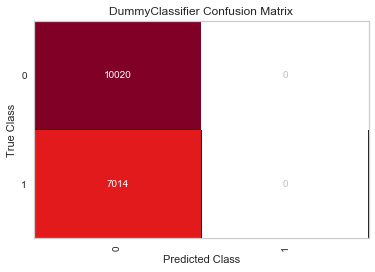

In [5]:
m.dummy_binary(X_train_cm, y_train, X_test_cm, y_test)

UNBALANCED REGRESSION
Test Accuracy score:  0.6190560056357872
Test F1 score:  0.34986474301172227


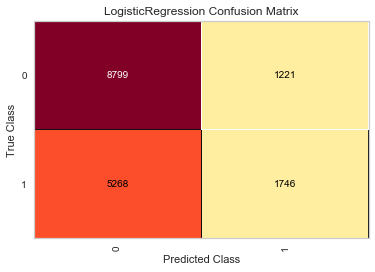

In [6]:
m.reg_unbalanced(X_train_cm, y_train, X_test_cm, y_test)

In [7]:
sm_val = SMOTE(random_state=42, ratio=1.0)
Xs_train, ys_train = sm_val.fit_sample(X_train, y_train)

In [8]:
scaler = StandardScaler()
Xs_train_cm = Xs_train
X_test_cm = X_test
scaler.fit(Xs_train_cm)
Xs_train_cm = scaler.transform(Xs_train_cm)
X_test_cm = scaler.transform(X_test_cm)

DUMMY REGRESSION
Test Accuracy score:  0.5882352941176471


C:\Users\Rocio\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test F1 score:  0.0


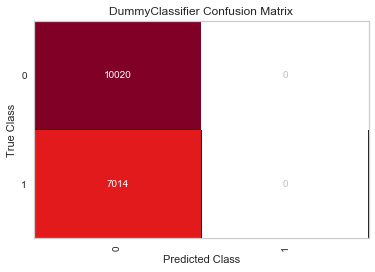

In [9]:
m.dummy_binary(Xs_train_cm, ys_train, X_test_cm, y_test)

UNBALANCED REGRESSION
Test Accuracy score:  0.5767288951508748
Test F1 score:  0.45254365983295364


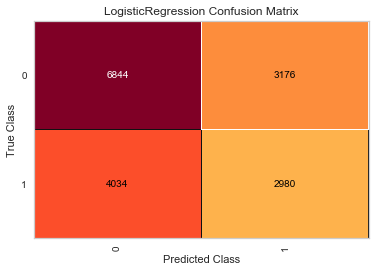

In [10]:
m.reg_unbalanced(Xs_train_cm, ys_train, X_test_cm, y_test)

In [11]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        print(f'best_k: {best_k}')
        print(f'best_score: {best_score}')
        print(f'k: {k}')
        print(f'f1_score: {f1}')
        if f1 > best_score:
            best_k = k
            best_score = f1
        print(f'best_k is now {best_k}')
        print(f'best_score is now {best_score}\n')
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [12]:
find_best_k(Xs_train_cm, ys_train, X_test_cm, y_test)

best_k: 0
best_score: 0.0
k: 1
f1_score: 0.46
best_k is now 1
best_score is now 0.46

best_k: 1
best_score: 0.46
k: 3
f1_score: 0.4471733759627961
best_k is now 1
best_score is now 0.46

best_k: 1
best_score: 0.46
k: 5
f1_score: 0.44935679432204645
best_k is now 1
best_score is now 0.46

best_k: 1
best_score: 0.46
k: 7
f1_score: 0.45301385248970427
best_k is now 1
best_score is now 0.46

best_k: 1
best_score: 0.46
k: 9
f1_score: 0.45549342602387793
best_k is now 1
best_score is now 0.46

best_k: 1
best_score: 0.46
k: 11
f1_score: 0.4557693770441926
best_k is now 1
best_score is now 0.46

best_k: 1
best_score: 0.46
k: 13
f1_score: 0.4529082688328608
best_k is now 1
best_score is now 0.46

best_k: 1
best_score: 0.46
k: 15
f1_score: 0.45024570024570026
best_k is now 1
best_score is now 0.46

best_k: 1
best_score: 0.46
k: 17
f1_score: 0.4504255808603635
best_k is now 1
best_score is now 0.46

best_k: 1
best_score: 0.46
k: 19
f1_score: 0.4524231450805147
best_k is now 1
best_score is now 0.

In [13]:
for num in list(range(1, 11)):
    estimator = tree.DecisionTreeClassifier(
        criterion='entropy', max_depth=(num))
    estimator.fit(Xs_train, ys_train)
    print(f"num: {num}")
    print('estimatorn R2 score: ', estimator.score(Xs_train, ys_train),
          '\nestimator_importances: ', estimator.feature_importances_)
    print('estimatorn R2 score_test: ', estimator.score(X_test, y_test))

num: 1
estimatorn R2 score:  0.5321548207356307 
estimator_importances:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
estimatorn R2 score_test:  0.6145943407303041
num: 2
estimatorn R2 score:  0.5321548207356307 
estimator_importances:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.54723297 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.45276703 0.         0.         0.
 0.         0.         0.         0.        ]
estimatorn R2 score_test:  0.6145943407303041
num: 3
estimatorn R2 score:  0.5739776458492256 
estimator_importances:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.37023994 0.02447516 0.         0.
 0.         0.         0.         0.         0. 

In [ ]:
m.reg_unbalanced(xs_train, ys_train, X_test, y_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
len(ys_train)

In [ ]:
X_train_cm = xs_train
X_test_cm = X_test

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train_cm)

X_train_cm = scaler.transform(X_train_cm)

X_test_cm = scaler.transform(X_test_cm)

m.reg_unbalanced(X_train_cm, ys_train, X_test_cm, y_test)

In [ ]:
m.smote(X_train_cm, y_train, X_test_cm, y_test)

In [ ]:
corr

In [ ]:
columns 

In [ ]:
m.run_all_regressions(X_no_nbr, y)

In [ ]:
m.run_all_regressions(X, y)

In [ ]:
rfc = RandomForestClassifier(n_estimators=300, max_features= 'sqrt', max_depth= 5,  oob_score=True)
cv = cross_validate(rfc, X, y, return_estimator=True, cv=5)
est = cv['estimator'][3]

print(est.oob_score_)

index = X.columns.tolist()
feat_imp = pd.DataFrame(est.feature_importances_, index = index, columns = ['importances'])
feat_imp.sort_values(by = 'importances', ascending = False)

In [ ]:
data = f.concat(X, y)

In [ ]:
data_gluc = data.loc[(data['glu_200_300'] == 1) | (data['glu_over_300'] == 1) | (data['glu_norm'] == 1)]

data_a1 = data.loc[(data['a1_7_8'] == 1) | (data['a1_norm'] == 1) | (data['al_over_8'] == 1)]

data_gluc = data_gluc.drop(columns = ['icd_11', 'icd_14', 'icd_15', 'repaglinide_up', 'glimepiride_down',
                                     'glimepiride_up', 'pioglitazone_down', 'pioglitazone_up',
                                      'rosiglitazone_down', 'rosiglitazone_up'])

X_gluc = data_gluc.drop(columns = ['readmitted'])
y_gluc = data_gluc.readmitted

In [ ]:
m.run_all_regressions(X_gluc, y_gluc)

In [ ]:
rfc = RandomForestClassifier(n_estimators=300, max_features= 'sqrt', max_depth= 5,  oob_score=True)
cv = cross_validate(rfc, X_gluc, y_gluc, return_estimator=True, cv=5)
est = cv['estimator'][3]

print(est.oob_score_)

index = X_gluc.columns.tolist()
feat_imp = pd.DataFrame(est.feature_importances_, index = index, columns = ['importances'])
feat_imp.sort_values(by = 'importances', ascending = False)

In [ ]:
def y_split_race(X_train, y_train):
    training = pd.concat([X_train, y_train], axis=1)
    training_aa = training[training['african_american'] == 1]
    training_asian = training[training['asian'] == 1]
    training_hispanic = training[training['hispanic'] == 1]
    training_other = training[training['other'] == 1]
    training_cauc = training[(training['african_american'] == 0) & (
        training['asian'] == 0) & (training['hispanic'] == 0) & (training['other'] == 0)]
    return training_aa, training_asian, training_hispanic, training_other, training_cauc

In [ ]:
gluc_aa, gluc_asian, gluc_hispanic, gluc_other, gluc_cauc = y_split_race(X_gluc, y_gluc)

gluc_aa_upsampled = resample(gluc_aa,
                             replace=True,  # sample with replacement
                             # match number in majority class
                             n_samples=len(gluc_cauc),
                             random_state=23)  # reproducible results
gluc_asian_upsampled = resample(gluc_asian,
                                replace=True,  # sample with replacement
                                # match number in majority class
                                n_samples=len(gluc_cauc),
                                random_state=23)  # reproducible results
gluc_hispanic_upsampled = resample(gluc_hispanic,
                                   replace=True,  # sample with replacement
                                   # match number in majority class
                                   n_samples=len(gluc_cauc),
                                   random_state=23)  # reproducible results
gluc_other_upsampled = resample(gluc_other,
                                replace=True,  # sample with replacement
                                # match number in majority class
                                n_samples=len(gluc_cauc),
                                random_state=23)  # reproducible results

upsampled = pd.concat([gluc_cauc, gluc_aa_upsampled, gluc_asian_upsampled,
                       gluc_hispanic_upsampled, gluc_other_upsampled])

upsampled_X = upsampled.drop(columns = ['readmitted'])
upsampled_y = upsampled.readmitted

X_train, X_test, y_train, y_test = train_test_split(
    upsampled_X, upsampled_y, test_size=0.25, random_state=23)

dummy_binary(X_train, y_train, X_test, y_test)

reg_unbalanced(X_train, y_train, X_test, y_test)

no, yes = y_split(X_train, y_train)

upsample(no, yes, X_test, y_test)

downsampled(no, yes, X_test, y_test)

smote(upsampled_X, upsampled_y, test_size=0.25, random_state=23)

rfc = RandomForestClassifier(n_estimators=300, max_features= 'sqrt', max_depth= 5,  oob_score=True)
cv = cross_validate(rfc, upsampled_X, upsampled_y, return_estimator=True, cv=5)
est = cv['estimator'][3]

print(est.oob_score_)

index = upsampled_X.columns.tolist()
feat_imp = pd.DataFrame(est.feature_importances_, index = index, columns = ['importances'])
feat_imp.sort_values(by = 'importances', ascending = False)

rfc = RandomForestClassifier(n_estimators=300, max_features= 'sqrt', max_depth= 7,  oob_score=True)
cv = cross_validate(rfc, upsampled_X, upsampled_y, return_estimator=True, cv=5)
est = cv['estimator'][3]

print(est.oob_score_)

index = upsampled_X.columns.tolist()
feat_imp = pd.DataFrame(est.feature_importances_, index = index, columns = ['importances'])
feat_imp.sort_values(by = 'importances', ascending = False)

In [ ]:
gluc_cauc_downsampled = resample(gluc_cauc,
                             replace=True,  # sample with replacement
                             # match number in majority class
                             n_samples=len(gluc_aa),
                             random_state=23)  # reproducible results
gluc_asian_upsampled = resample(gluc_asian,
                                replace=True,  # sample with replacement
                                # match number in majority class
                                n_samples=len(gluc_aa),
                                random_state=23)  # reproducible results
gluc_hispanic_upsampled = resample(gluc_hispanic,
                                   replace=True,  # sample with replacement
                                   # match number in majority class
                                   n_samples=len(gluc_aa),
                                   random_state=23)  # reproducible results
gluc_other_upsampled = resample(gluc_other,
                                replace=True,  # sample with replacement
                                # match number in majority class
                                n_samples=len(gluc_aa),
                                random_state=23)  # reproducible results

midsampled = pd.concat([gluc_cauc_downsampled, gluc_aa, gluc_asian_upsampled,
                        gluc_hispanic_upsampled, gluc_other_upsampled])

midsampled_X = midsampled.drop(columns = ['readmitted'])
midsampled_y = midsampled.readmitted

X_train, X_test, y_train, y_test = train_test_split(
    midsampled_X, midsampled_y, test_size=0.25, random_state=23)

dummy_binary(X_train, y_train, X_test, y_test)

reg_unbalanced(X_train, y_train, X_test, y_test)

no, yes = y_split(X_train, y_train)

upsample(no, yes, X_test, y_test)

downsampled(no, yes, X_test, y_test)

smote(midsampled_X, midsampled_y, test_size=0.25, random_state=23)

In [ ]:
data_a1 = data_a1.drop(columns = ['icd_15', 'repaglinide_down'])

X_a1 = data_a1.drop(columns = ['readmitted'])
y_a1 = data_a1.readmitted

X_train, X_test, y_train, y_test = train_test_split(
    X_a1, y_a1, test_size=0.25, random_state=23)

dummy_binary(X_train, y_train, X_test, y_test)

reg_unbalanced(X_train, y_train, X_test, y_test)

no, yes = y_split(X_train, y_train)

upsample(no, yes, X_test, y_test)

downsampled(no, yes, X_test, y_test)

smote(X_a1, y_a1, test_size=0.25, random_state=23)

In [ ]:
data_a1_glu_200_300 = data_a1.loc[data_a1.glu_200_300 == 1]
data_a1_glu_over_300 = data_a1.loc[data_a1.glu_over_300 == 1]
data_a1_glu_norm = data_a1.loc[data_a1.glu_norm == 1]
data_a1_glu_none = data_a1.loc[(data_a1.glu_norm == 0)&(data_a1.glu_over_300 == 0)&(data_a1.glu_200_300 == 0)]

up_a1_glu_200_300 = resample(data_a1_glu_200_300,
                             replace=True,  # sample with replacement
                             # match number in majority class
                             n_samples=3120,
                             random_state=23)  # reproducible results
up_a1_glu_over_300 = resample(data_a1_glu_over_300,
                              replace=True,  # sample with replacement
                              # match number in majority class
                              n_samples=3120,
                              random_state=23)  # reproducible results
up_a1_glu_norm = resample(data_a1_glu_norm,
                          replace=True,  # sample with replacement
                          # match number in majority class
                          n_samples=3120,
                          random_state=23)  # reproducible results
up_a1_glu_none = resample(data_a1_glu_none,
                          replace=True,  # sample with replacement
                          # match number in majority class
                          n_samples=3120,
                          random_state=23)  # reproducible results

up_a1_gluc = pd.concat([up_a1_glu_200_300, up_a1_glu_over_300, up_a1_glu_norm])

up_a1_gluc_X = up_a1_gluc.drop(columns=['readmitted'])
up_a1_gluc_y = up_a1_gluc.readmitted

X_train, X_test, y_train, y_test = train_test_split(
    up_a1_gluc_X, up_a1_gluc_y, test_size=0.25, random_state=23)

dummy_binary(X_train, y_train, X_test, y_test)

reg_unbalanced(X_train, y_train, X_test, y_test)

no, yes = y_split(X_train, y_train)

upsample(no, yes, X_test, y_test)

downsampled(no, yes, X_test, y_test)

smote(up_a1_gluc_X, up_a1_gluc_y, test_size=0.25, random_state=23)